In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest


df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

# mccinfo sütunundan dört haneli değeri çekmek için fonksiyon
def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Sayısal sütunlardaki değerlerin düzenlenmesi
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunların kodlanması
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]

# Ölçekleme
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)


mccinfo değeri bulunamadığı için silinecek satır sayısı: 15


In [12]:
# Isolation Forest 
iso_forest = IsolationForest(contamination="auto", random_state=42)
outlier_labels = iso_forest.fit_predict(X_scaled)
inlier_mask = outlier_labels == 1
X_clean = X_scaled[inlier_mask]
y_clean = y[inlier_mask]
print(f"Isolation Forest sonrası kalan örnek sayısı: {X_clean.shape[0]}")


Isolation Forest sonrası kalan örnek sayısı: 1403


In [13]:
n_clusters = 5 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_clean)
X_clean['Cluster'] = clusters

print("Kümeleme işlemi tamamlandı. Küme dağılımı:")
print(pd.Series(clusters).value_counts())


Kümeleme işlemi tamamlandı. Küme dağılımı:
0    392
2    327
3    289
1    225
4    170
Name: count, dtype: int64


c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\yagiz\AppData\Local\Temp\ipykernel_12280\3398573696.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clean['Cluster'] = clusters


In [14]:
# Model Eğitimi ve Değerlendirme
all_predictions = pd.Series(index=y_clean.index, dtype=float)
cluster_metrics = {}

for cluster in np.unique(clusters):
    print(f"\nCluster {cluster} için model eğitimi başlatılıyor...")
    cluster_mask = X_clean['Cluster'] == cluster
    X_cluster = X_clean.loc[cluster_mask].drop(columns=['Cluster'])
    y_cluster = y_clean.loc[cluster_mask]
    
    # KFold ayarlaması: Küme örnek sayısına göre CV ayarlanıyor.
    if len(X_cluster) < 10:
        print(f"Uyarı: Cluster {cluster} için örnek sayısı {len(X_cluster)}, CV kat sayısı örnek sayısına göre ayarlanıyor.")
        kf = KFold(n_splits=len(X_cluster), shuffle=True, random_state=42)
    else:
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
        ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
    ])
    
    # Cross-validation ile tahminleri elde ediyoruz.
    y_pred_cluster = cross_val_predict(pipeline, X_cluster, y_cluster, cv=kf)
    
    mae = mean_absolute_error(y_cluster, y_pred_cluster)
    mape = mean_absolute_percentage_error(y_cluster, y_pred_cluster)
    r2 = r2_score(y_cluster, y_pred_cluster)
    
    cluster_metrics[cluster] = {'MAE': mae, 'MAPE': mape, 'R2': r2}
    print(f"Cluster {cluster} sonuçları:")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R2: {r2:.4f}")
    
    all_predictions.loc[cluster_mask] = y_pred_cluster

print("\nTüm kümeler için model sonuçları:")
print(cluster_metrics)

overall_mae = mean_absolute_error(y_clean, all_predictions)
overall_mape = mean_absolute_percentage_error(y_clean, all_predictions)
overall_r2 = r2_score(y_clean, all_predictions)
print("\nGenel model sonuçları:")
print(f"Genel MAE: {overall_mae:.4f}")
print(f"Genel MAPE: {overall_mape:.4f}")
print(f"Genel R2: {overall_r2:.4f}")




Cluster 0 için model eğitimi başlatılıyor...
Cluster 0 sonuçları:
MAE: 0.3503
MAPE: 0.0800
R2: 0.4120

Cluster 1 için model eğitimi başlatılıyor...
Cluster 1 sonuçları:
MAE: 0.4061
MAPE: 0.0910
R2: 0.0638

Cluster 2 için model eğitimi başlatılıyor...
Cluster 2 sonuçları:
MAE: 0.3671
MAPE: 0.0890
R2: 0.5335

Cluster 3 için model eğitimi başlatılıyor...
Cluster 3 sonuçları:
MAE: 0.3585
MAPE: 0.0827
R2: 0.5969

Cluster 4 için model eğitimi başlatılıyor...


c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\feature_

Cluster 4 sonuçları:
MAE: 0.4504
MAPE: 0.1053
R2: 0.0488

Tüm kümeler için model sonuçları:
{0: {'MAE': 0.3503460686547416, 'MAPE': 0.08002136712088916, 'R2': 0.41195424285764126}, 1: {'MAE': 0.4060799574110243, 'MAPE': 0.09104166920598727, 'R2': 0.0638151077913438}, 2: {'MAE': 0.3670512817977766, 'MAPE': 0.08897506428422768, 'R2': 0.5334700588182166}, 3: {'MAE': 0.3585387375445515, 'MAPE': 0.08269715739719201, 'R2': 0.5969140213529862}, 4: {'MAE': 0.4504160795211792, 'MAPE': 0.10526157099206891, 'R2': 0.04879337476774148}}

Genel model sonuçları:
Genel MAE: 0.3770
Genel MAPE: 0.0875
Genel R2: 0.4410


c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


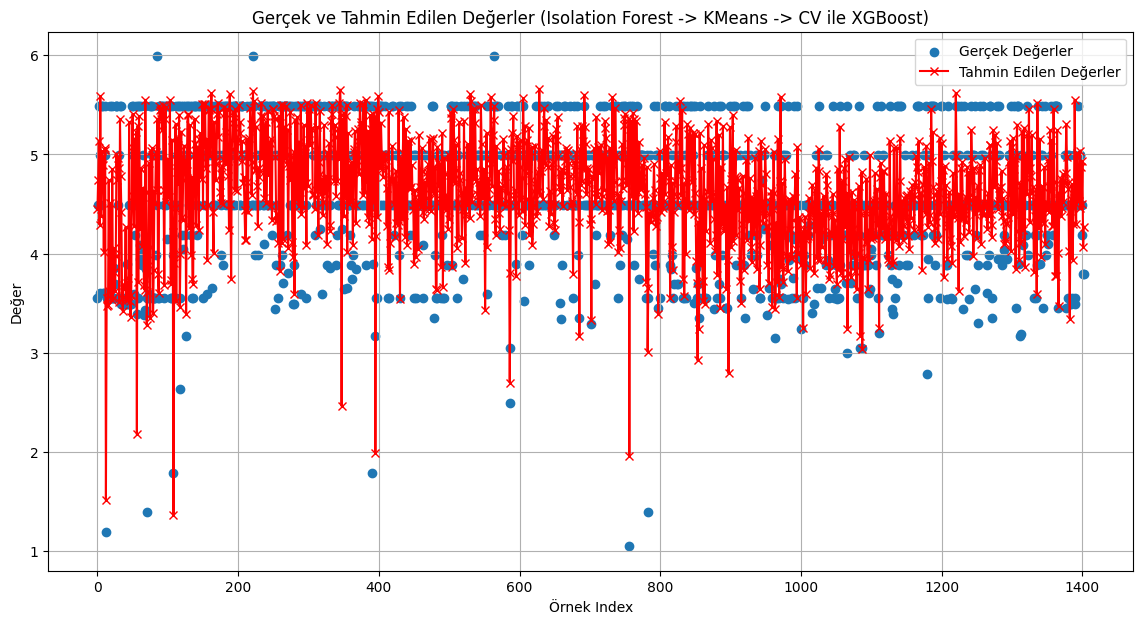

In [15]:
plt.figure(figsize=(14,7))
plt.scatter(np.arange(len(y_clean)), y_clean, label="Gerçek Değerler", marker="o")
plt.plot(np.arange(len(y_clean)), all_predictions.sort_index(), label="Tahmin Edilen Değerler", marker="x", color="red", linestyle="-")
plt.xlabel("Örnek Index")
plt.ylabel("Değer")
plt.title("Gerçek ve Tahmin Edilen Değerler (Isolation Forest -> KMeans -> CV ile XGBoost)")
plt.legend()
plt.grid(True)
plt.show()
